# Algorithm of Smart Parking Planning
**Team 8: Shi Hu, Jixiong Deng, Liyu Chen**

In [ ]:
# Install osmnx
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx==0.16.2 --quiet
!pip install folium --quiet
!pip install scipy
!pip install pyswarms
!pip install geneticalgorithm
#!pip uninstall matplotlib
!pip install -U matplotlib
!pip install tabulate

!pip install -U -q PyDrive

In [ ]:
pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
click==7.1.2
click-plugins==1.1.1
cligj==0.7.1
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.4
dlib==19.18.0
dm

In [ ]:
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import json
import sys
import time

import pandas as pd
import io
from itertools import cycle
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from math import sin, cos, sqrt, atan2, radians

# 1. Dataset

Our data is constructed based on the open data of all on-street metered parking spaces in the City of Los Angeles. 


*   The basic information of all the parking spaces is available at https://data.lacity.org/Transportation/LADOT-Metered-Parking-Inventory-Policies/s49e-q6j2
*   The real-time occupancy of each parking space is available at https://data.lacity.org/Transportation/LADOT-Parking-Meter-Occupancy/e7h6-4a3e

We calculated the maximum rate (MaxRate) within time limit for all type of parking space


*   FLAT: hourly rate * hour limit
*   JUMP: maximum price
*   SEASONAL: winter hourly rate * hour limit
*   JUMP: maximum hourly rate * hour limit








In [ ]:
# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# #### JASON - with filtered Friday morning occupancy
# link = 'https://drive.google.com/file/d/1B4jTo6dWk67YMbpg2UzO330JIfXHoqJp/view?usp=sharing' # The shareable link
# id='1B4jTo6dWk67YMbpg2UzO330JIfXHoqJp'
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('filtered_ext_FriAM.json') 

#extract data with following attributes from json file
'''
type: text
    Single-space parking space can be viewed as node type
SpaceID: text
    Unique ID of the metered street parking space 
BlockFace: text
    Block number and street of metered space
HourLimit: float
    Maximum parking time limit during metered hours
RateType: text
    Hourly rate type - FLAT, JUMP, SEASONAL, Time-of-Day (TOD)
HourlyRate: float
    The minimum hourly rate 
MaxRate: float
    The maximum rate calculated within hour limit
OccupancyState: integar
    0 - Vacant; 1 - Occupied
Latitude: float
Longitude: float
'''
uploaded_file=files.upload()
with open('filtered_ext_FriAM.json') as json_file:
    itemData = json.load(json_file)
print(len(itemData))

Saving filtered_ext_FriAM.json to filtered_ext_FriAM (1).json
298


## 1.1 Parking Data


*   Our dataset for tests contains 298 parking sapces in downtown LA



In [ ]:
## Start point area
## "Los Angeles dt" 34.047937, -118.261253 southfigueroa&8th 34.029588, -118.232241 mateo&E8th
north, west, south, east = 34.047937, -118.261253, 34.029588, -118.232241
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive') 
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

## Extract parking lat/long 
parkings=[]
p_lat=[]
p_long=[]
vacant_parkings=[]
vacp_lat=[]
vacp_long=[]
node_lat=[]
node_long=[]
for item in itemData:
  # let lat/long for all parking space
  parkings.append(item)
  p_lat.append(item["Latitude"])
  p_long.append(item["Longitude"])
  # find the nearest nodes for the parking space
  nearest_node=ox.get_nearest_node(G,(item["Latitude"],item["Longitude"]))
  node_lat.append(G.nodes[nearest_node]['y'])
  node_long.append(G.nodes[nearest_node]['x'])
  # get lat/long for vacant parking space
  if item["OccupancyState"] == 0:
    vacant_parkings.append(item)
    vacp_lat.append(item["Latitude"])
    vacp_long.append(item["Longitude"])

# print(len(p_lat),len(node_lat),len(vacp_lat))

## 1.2 Test Cases

*   Selected 10 pairs of start/destination to simulation users finding parking space in downtown LA
*   Plotted figure of parking spaces with occupancy state, and start/destination points



In [ ]:
# Add test cases features to the figure
def fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours):
  #all parking space
  fig.add_trace(go.Scattermapbox(
          name = "Occupied parking",
          mode = "markers",
          lat = p_lat,
          lon = p_long,
          marker = {'size': 5, 'color':"orange"}))
  #currently available parking space
  hover_text = []
  for i in range(len(vacant_parkings)):
    hover_text.append('Hourly rate: ' + str(vacant_parkings[i]['HourlyRate']) + '; Max rate: ' + str(vacant_parkings[i]['MaxRate']) + '; Hour Limit: ' + str(vacant_parkings[i]['HourLimit']))
  fig.add_trace(go.Scattermapbox(
          name = "Vacant parking",
          mode = "markers",
          lat = vacp_lat,
          lon = vacp_long,
          marker = {'size': 5, 'color':"darkgreen"},
          hoverinfo = 'text',
          hovertext = hover_text))
  #start points
  for i in range(len(origin_lat)):
    start_name = 'Start point ' + str(i)
    fig.add_trace(go.Scattermapbox(
            name = start_name,
            mode = "markers",
            lat = [origin_lat[i]],
            lon = [origin_long[i]],
            marker = {'size': 10, 'color':"blue"}))
  #detinations
  for i in range(len(dest_lat)):
    dest_name = 'Destination ' + str(i)
    hover_text = dest_name + '; Hours: ' + str(hours[i])
    fig.add_trace(go.Scattermapbox(
            name = dest_name,
            mode = "markers",
            lat = [dest_lat[i]],
            lon = [dest_long[i]],
            marker = {'size': 10, 'color':"red"},
            hoverinfo = 'text',
            hovertext = hover_text))

  # getting center for plots:
  lat_center = np.mean(origin_lat)
  long_center = np.mean(origin_long)
  # defining the layout using mapbox_style
  fig.update_layout(mapbox_style="carto-positron",
      mapbox_center_lat = 30, mapbox_center_lon=-80)
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                    mapbox = {
                        'center': {'lat': lat_center, 
                        'lon': long_center},
                        'zoom': 14.5})
  
  return fig

# Helper to plot paths
def fig_add_path(fig, lat, long, name, palette):
  fig.add_trace(go.Scattermapbox(
      name = name,
      mode = "lines",
      lon = long,
      lat = lat,
      marker = {'size': 10},
      line = dict(width = 4.5, color = next(palette))))
  
  return fig

def fig_add_result_paths(fig, row_ind, col_ind, list_V, list_P):
  palette = cycle(px.colors.qualitative.Plotly)
  for i, j in zip(row_ind, col_ind):
    name = 'path_' + str(i)
    path_lat, path_long = path_lat_long(list_V[i], list_P[j], G)
    fig = fig_add_path(fig, path_lat, path_long, name, palette)
  
  return fig


In [ ]:
#Test cases: 10 cases
#Start point coordinates
origin_lat=[34.038526, 34.034314, 34.043959, 34.038329, 34.040802, 34.038147, 34.034895, 34.042111, 34.046061, 34.03682]
origin_long=[-118.254028, -118.252074, -118.243785, -118.245367, -118.260495, -118.257064, -118.253033, -118.244735, -118.242705, -118.248662]
#Destination coordinates
dest_lat=[34.042308, 34.041665, 34.039068, 34.040547, 34.041726, 34.040755, 34.042034, 34.041959, 34.039944, 34.041198]
dest_long=[-118.250414, -118.251708, -118.251934, -118.246945, -118.248157, -118.251687, -118.247397, -118.252433, -118.252114, -118.246792]
#Desired parking hours
hours=[2.0, 2.0, 2.5, 1, 0.5, 1, 2.5, 3, 1.5, 0.5]
#Colors used to plot path
colours = ['red', 'orange', 'yellow', 'green', 'blue', 'azure', 'purple', 'black', 'olive', 'firebrick']

#Plot figure for dataset and test cases
fig = go.Figure()
fig = fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours)
fig.show()

# 2. Model and Algorithm









In [ ]:
# Define constants
RATE_ALPHA = 1
WALK_SPEED = 1.5
NUM_V = len(origin_lat)
NUM_P = len(vacant_parkings)
LARGER_NUM = 1000000
print(NUM_V, NUM_P)

10 139


## Helpers

In [ ]:
'''
These are helpers necessay to compute the cost matrix.
'''
# Generate vehicle list
def vehicle_list(origin_lat, origin_long, dest_lat, dest_long, hours):
  list_V = []
  for i in range(NUM_V):
    origin_node, origin_dist = ox.distance.get_nearest_node(G, (origin_lat[i], origin_long[i]), method='haversine', return_dist=True)
    dest_node, dest_dist = ox.distance.get_nearest_node(G, (dest_lat[i], dest_long[i]), method='haversine', return_dist=True)
    dict_V = {
        "origin_lat": origin_lat[i],
        "origin_long": origin_long[i],
        "dest_lat": dest_lat[i],
        "dest_long": dest_long[i],
        "hours": hours[i],
        "origin_node": origin_node,
        "origin_dist": origin_dist,
        "dest_node": dest_node,
        "dest_dist": dest_dist
        }
    list_V.append(dict_V)
  
  return list_V

# Generate parking lot list
def parking_list(vacant_parkings):
  list_P = []
  for i in range(NUM_P):
    node, dist = ox.distance.get_nearest_node(G, (vacant_parkings[i]["Latitude"], vacant_parkings[i]["Longitude"]), method='haversine', return_dist=True)
    dict_P = {
        "lat": vacant_parkings[i]["Latitude"],
        "long": vacant_parkings[i]["Longitude"],
        "node": node,
        "dist": dist,
        "RateType": vacant_parkings[i]["RateType"],
        "HourlyRate": vacant_parkings[i]["HourlyRate"],
        "HourLimit": vacant_parkings[i]["HourLimit"],
        "MaxRate": vacant_parkings[i]["MaxRate"]
        }
    list_P.append(dict_P)
  
  return list_P

# Computer distance between two lat-longs
def dist_lat_long(lat1, long1, lat2, long2):
  # approximate radius of earth in km
  R = 6373.0

  lat1 = radians(lat1)
  long1 = radians(long1)
  lat2 = radians(lat2)
  long2 = radians(long2)

  dlon = long2 - long1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  
  return distance * 1000

# Compute move time between the actual location and the nearest node
def time_to_node(lat, long, node_id, walk = False):
  node = G.nodes[node_id]
  u, v, key = ox.distance.get_nearest_edge(G, (lat, long))
  edge = G[u][v][key]
  speed = edge["speed_kph"]
  speed = speed / 3.6

  if walk:
    speed = WALK_SPEED
  
  dist = dist_lat_long(lat, long, node["y"], node["x"])
  time = dist/speed

  return time

# Compute travel time (in minutes) for a vehicle-parking pair
def get_drive_time(v, p, G):
  # Travel time between two end nodes
  path = ox.distance.shortest_path(G, v["origin_node"], p["node"], weight='length')
  time_list = ox.utils_graph.get_route_edge_attributes(G, path, attribute="travel_time", minimize_key='length')
  time_list = np.array(time_list)
  time = np.sum(time_list)
  # Drive time between actual locations and nodes
  start_time = time_to_node(v["origin_lat"], v["origin_long"], v["origin_node"])
  end_time = time_to_node(p["lat"], p["long"], p["node"])
  time = time + start_time + end_time
  
  return time

def get_walk_time(v, p, G):
  # Travel time between two end nodes
  path = ox.distance.shortest_path(G, v["dest_node"], p["node"], weight='length')
  length_list = ox.utils_graph.get_route_edge_attributes(G, path, attribute="length", minimize_key='length')
  length_list = np.array(length_list)
  length_list = np.sum(length_list)
  time = length_list / WALK_SPEED
  # Drive time between actual locations and nodes
  start_time = time_to_node(v["dest_lat"], v["dest_long"], v["dest_node"], walk = True)
  end_time = time_to_node(p["lat"], p["long"], p["node"], walk = True)
  time = time + start_time + end_time
  
  return time

# Compute the drive time matrix
def get_D(list_V, list_P, G):
  D = np.zeros((NUM_V, NUM_P))
  for i in range(NUM_V):
    for j in range(NUM_P):
      v = list_V[i]
      p = list_P[j]
      if v['hours'] > p['HourLimit']:
        D[i][j] = LARGER_NUM
      else:
        D[i][j] = get_drive_time(v, p, G)
    
  return D

# Compute the walk time matrix
def get_W(list_V, list_P, G):
  W = np.zeros((NUM_V, NUM_P))
  for i in range(NUM_V):
    for j in range(NUM_P):
      v = list_V[i]
      p = list_P[j]
      if v['hours'] > p['HourLimit']:
        W[i][j] = 0
      else:
        W[i][j] = get_walk_time(v, p, G)
    
  return W

# Compute the rate matrix
def get_R(list_V, list_P, G):
  R = np.zeros((NUM_V, NUM_P))
  for i in range(NUM_V):
    for j in range(NUM_P):
      v = list_V[i]
      p = list_P[j]
      fee = v['hours'] * p['HourlyRate'] 
      if fee > p['MaxRate']:
        fee = p['MaxRate']
      R[i][j] = fee
    
  return R

# Reconstruct path
def path_lat_long(v, p, G):
  path_lat = [v['origin_lat']]
  path_long = [v['origin_long']]

  # Driving part
  d_path = ox.distance.shortest_path(G, v['origin_node'], p['node'], weight='length')
  for d_node in d_path:
    path_lat.append(G.nodes[d_node]['y'])
    path_long.append(G.nodes[d_node]['x'])
  path_lat.append(p['lat'])
  path_long.append(p['long'])

  # Walk Part
  w_path = ox.distance.shortest_path(G, p["node"], v["dest_node"], weight='length')
  for w_node in w_path:
    path_lat.append(G.nodes[w_node]['y'])
    path_long.append(G.nodes[w_node]['x'])
  path_lat.append(v['dest_lat'])
  path_long.append(v['dest_long'])

  return path_lat, path_long


## Problem Modelling

In [ ]:
'''
Actual algorithms and problem modelling starts here.
'''
start_time = time.time()

# Prepare lists
list_V = vehicle_list(origin_lat, origin_long, dest_lat, dest_long, hours)
list_P = parking_list(vacant_parkings)

# Compute the cost matrix C
D = get_D(list_V, list_P, G)
W = get_W(list_V, list_P, G)
R = get_R(list_V, list_P, G)
R_penalty = RATE_ALPHA * np.multiply(R, W)
C = D + W + R_penalty

print("--- Time to compute C: %s seconds ---" % (time.time() - start_time))

--- Time to compute C: 167.9888072013855 seconds ---


## Basic Greedy Algorithm

In [ ]:
def basic_greedy(C):
  X = np.zeros((NUM_V, NUM_P))
  P_ind = []
  for i in range(NUM_V):
    sorted_ind = np.argsort(C[i])[ : NUM_V]
    for ind in sorted_ind:
      if ind not in P_ind:
        P_ind.append(ind)
        # print(C[i][ind])
        break
  
  for i in range(NUM_V):
    X[i][P_ind[i]] = 1
  
  return X


In [ ]:
start_time = time.time()
greedy_X = basic_greedy(C)
greedy_runtime = time.time() - start_time
print("--- Greedy run time: %s seconds ---" % greedy_runtime)

# Show results
greedy_row_ind = []
greedy_col_ind = []
for i in range(NUM_V):
  greedy_row_ind.append(i)
  row = greedy_X[i]
  greedy_col_ind.append(np.argwhere(row == 1)[0][0])

greedy_cost = np.sum(np.multiply(greedy_X, C))
print('Greedy cost: ', greedy_cost)
print('Greedy assignment: ', greedy_col_ind)

--- Greedy run time: 0.0003197193145751953 seconds ---
Greedy cost:  3490.9193571218802
Greedy assignment:  [84, 117, 24, 59, 72, 73, 97, 128, 48, 95]


In [ ]:
# Plot results
fig = go.Figure()
fig = fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours)
fig = fig_add_result_paths(fig, greedy_row_ind, greedy_col_ind, list_V, list_P)
fig.show()

## Hungarian Method

In [ ]:
from scipy.optimize import linear_sum_assignment

# Hungarian method goes here
start_time = time.time()
hun_row_ind, hun_col_ind = linear_sum_assignment(C)
hungarian_runtime = time.time() - start_time
print("--- Hungarian run time: %s seconds ---" % hungarian_runtime)

# Plot results
fig = go.Figure()
fig = fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours)
fig = fig_add_result_paths(fig, hun_row_ind, hun_col_ind, list_V, list_P)
fig.show()

--- Hungarian run time: 0.00041604042053222656 seconds ---


In [ ]:
hun_X = np.zeros((NUM_V, NUM_P))
for i in range(NUM_V):
  hun_X[hun_row_ind[i], hun_col_ind[i]] = 1

hungarian_cost = np.sum(np.multiply(hun_X, C))
print("Hungarian cost: ", hungarian_cost)
print("Hungarian assignment: ", hun_col_ind)

Hungarian cost:  3479.1492051474625
Hungarian assignment:  [ 72 117  24  59  50  73  97  84  48  95]


## Differential Evolution Algorithm

In [ ]:
from scipy.optimize import differential_evolution

# Define the objective function here
def DE_objective_function(X, C):
  X = np.reshape(X, (NUM_V, NUM_P))

  # X[i][j] must be either 1 or 0
  # Force each element of X to be an integer
  X = np.around(X)
  cost = np.sum(np.multiply(X, C))

  # Constraints goes here
  # Sum of each row of X equals 1
  # Sum of each column of X <= 1
  penalty = 0
  for i in range(NUM_V):
    row_sum = X[i].sum()
    penalty += LARGER_NUM * np.abs(row_sum - 1)
  for j in range(NUM_P):
    col_sum = X[:, j].sum()
    if col_sum > 1:
      penalty += LARGER_NUM * (col_sum - 1)
      
  return cost + penalty

# Initialization solution for DE
def random_solution():
  X0 = np.zeros((NUM_V, NUM_P))
  col_ind = []
  for i in range(NUM_V):
    while True:
      rand_ind = np.random.randint(NUM_P)
      if rand_ind not in col_ind:
        col_ind.append(rand_ind)
        break

  for i in range(NUM_V):
    X0[i][col_ind[i]] = 1
  
  return X0
  

In [ ]:
start_time = time.time()
# Set bounds for each variable
bounds = []
for i in range(NUM_V * NUM_P):
  bounds.append((0, 1))

# Give a eligible random initialization
pop_size = 20
X_init = np.zeros((pop_size, NUM_P * NUM_V))
init_cost = LARGER_NUM * 10
for i in range(pop_size):
  X0 = random_solution()
  # Record lowest cost in the initialization
  this_cost = np.sum(np.multiply(X0, C))
  if this_cost < init_cost:
    init_cost = this_cost
  X_init[i] = X0.flatten()

print('Initialization cost: ', init_cost)

DE_res = differential_evolution(DE_objective_function, bounds, args = (C, ), init = X_init, maxiter = 10000, popsize = pop_size)

DE_runtime = time.time() - start_time
print("--- DE run time: %s seconds ---" % DE_runtime)

# Show results and prepare for plotting
DE_X = DE_res.x
DE_X = np.around(DE_X)
DE_X = np.reshape(DE_X, (NUM_V, NUM_P))

DE_row_ind = []
DE_col_ind = []
for i in range(NUM_V):
  DE_row_ind.append(i)
  row = DE_X[i]
  DE_col_ind.append(np.argwhere(row == 1)[0][0])

DE_cost = DE_res.fun
print("DE cost: ", DE_cost)
print("DE assignment: ", DE_col_ind)

Initialization cost:  1011146.4300869539
--- DE run time: 13.75355839729309 seconds ---
DE cost:  8890.257983711217
DE assignment:  [28, 41, 72, 24, 115, 117, 105, 88, 60, 75]


In [ ]:
# Plot results
fig = go.Figure()
fig = fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours)
fig = fig_add_result_paths(fig, DE_row_ind, DE_col_ind, list_V, list_P)
fig.show()

## Swarm Intelligence

In [ ]:
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import plot_cost_history

# Define the objective function here
def SI_objective_function(X, C, n_particles):
  # X in shape of (n_particles, NUM_V, NUM_P)
  X = np.reshape(X, (n_particles, NUM_V))
  X = np.around(X)
  cost = np.zeros(n_particles)

  for i in range(n_particles):
    # X[i][j] must be either 1 or 0
    # Force each element of X to be an integer
    X_i = np.zeros((NUM_V, NUM_P)) 
    for j in range(NUM_V):
      X_i[j][int(X[i][j])] = 1

    cost_i = np.sum(np.multiply(X_i, C))

    # Constraints goes here
    # Sum of each row of X equals 1
    # Sum of each column of X <= 1
    penalty = 0
    for k in range(NUM_P):
      col_sum = X_i[:, k].sum()
      if col_sum > 1:
        penalty += LARGER_NUM * (col_sum - 1)
    
    cost[i] = cost_i + penalty
        
  return cost

--- SI run time: 40.340291261672974 seconds ---
Swarm Intelligence cost:  4219.900200984221
Swarm Intelligence assignment:  [ 50.  94. 103.  95.  88.  24. 106.  72.  48.  59.]


<AxesSubplot:title={'center':'Cost History'}, xlabel='Iterations', ylabel='Cost'>

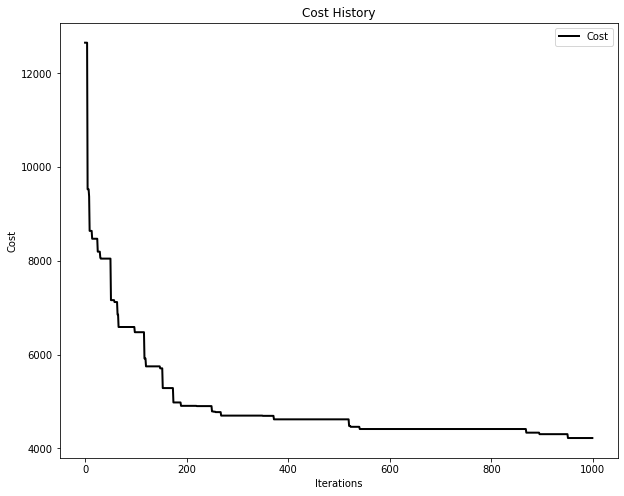

In [ ]:
start_time = time.time()
# Set bounds for each variable
x_min = np.full(NUM_V, 0)
x_max = np.full(NUM_V, NUM_P - 1)
SI_bounds = (x_min, x_max)

# Give a eligible random initialization
n_particles = 100

# instatiate the optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles = n_particles, dimensions = NUM_V, options = options, bounds = SI_bounds)
SI_cost, SI_pos = optimizer.optimize(SI_objective_function, iters = 1000, verbose = False, C = C, n_particles = n_particles)

SI_runtime = time.time() - start_time
print("--- SI run time: %s seconds ---" % SI_runtime)

# Show results and prepare for plotting
SI_pos = np.around(SI_pos)

SI_row_ind = []
SI_col_ind = []
for i in range(NUM_V):
  SI_row_ind.append(i)
  SI_col_ind.append(int(SI_pos[i]))

print("Swarm Intelligence cost: ", SI_cost)
print("Swarm Intelligence assignment: ", SI_pos)

plot_cost_history(cost_history = optimizer.cost_history)

In [ ]:
# Plot results
fig = go.Figure()
fig = fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours)
fig = fig_add_result_paths(fig, SI_row_ind, SI_col_ind, list_V, list_P)
fig.show()

## Genetic Algorithm

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

# Define the objective function here
def GA_objective_function(X):
  X = np.reshape(X, (NUM_V, NUM_P))

  # X[i][j] must be either 1 or 0
  # Force each element of X to be an integer
  X = np.around(X)
  cost = np.sum(np.multiply(X, C))

  # Constraints goes here
  # Sum of each row of X equals 1
  # Sum of each column of X <= 1
  penalty = 0
  for i in range(NUM_V):
    row_sum = X[i].sum()
    penalty += LARGER_NUM * np.abs(row_sum - 1)
  for j in range(NUM_P):
    col_sum = X[:, j].sum()
    if col_sum > 1:
      penalty += LARGER_NUM * (col_sum - 1)
      
  return cost + penalty

# Define the objective function here
def GA_objective_function_2(v):
  X = np.zeros((NUM_V, NUM_P))
  for i in range(NUM_V):
    X[i][int(v[i])] = 1

  # X[i][j] must be either 1 or 0
  # Force each element of X to be an integer
  X = np.around(X)
  cost = np.sum(np.multiply(X, C))

  # Constraints goes here
  # Sum of each row of X equals 1
  # Sum of each column of X <= 1
  penalty = 0
  for j in range(NUM_P):
    col_sum = X[:, j].sum()
    if col_sum > 1:
      penalty += LARGER_NUM * (col_sum - 1)
      
  return cost + penalty


 The best solution found:
 [ 72. 117.  51.  43.  50.  24.  97.  84.  48.  75.]

 Objective function:
 3619.136389222591


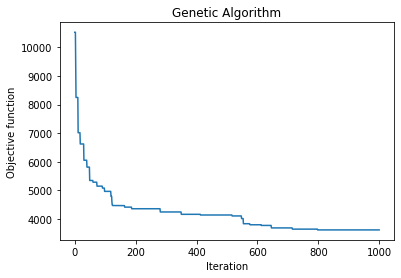

--- GA run time: 59.60599374771118 seconds ---


In [ ]:
start_time = time.time()
algorithm_param = {'max_num_iteration': 1000,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound=np.array([[0,NUM_P-1]]*NUM_V)

model=ga(function = GA_objective_function_2, dimension = NUM_V, variable_type = 'int', algorithm_parameters = algorithm_param, variable_boundaries = varbound)

model.run()

GA_runtime = time.time() - start_time
print("--- GA run time: %s seconds ---" % GA_runtime)

In [ ]:
# Show results and prepare for plotting
GA_pos = np.around(model.output_dict['variable'])

GA_row_ind = []
GA_col_ind = []
for i in range(NUM_V):
  GA_row_ind.append(i)
  GA_col_ind.append(int(GA_pos[i]))

GA_cost = model.output_dict['function']
print("GA cost: ", GA_cost)
print("GA assignment: ", GA_col_ind)

GA cost:  3619.136389222591
GA assignment:  [72, 117, 51, 43, 50, 24, 97, 84, 48, 75]


In [ ]:
# Plot results
fig = go.Figure()
fig = fig_add_test_cases(fig, p_lat, p_long, vacp_lat, vacp_long, vacant_parkings, origin_lat, origin_long, dest_lat, dest_long, hours)
fig = fig_add_result_paths(fig, GA_row_ind, GA_col_ind, list_V, list_P)
fig.show()

# 4. Summary

In [ ]:
from tabulate import tabulate

table = [["Greedy", greedy_cost, greedy_runtime],
         ["Hungarian", hungarian_cost, hungarian_runtime],
         ["DE", DE_cost, DE_runtime],
         ["SI", SI_cost, SI_runtime],
         ["GA", GA_cost, GA_runtime]]

headers = ["Method","Cost", "Runtime"]
print(tabulate(table, headers = headers))


print('Greedy assignment: ', greedy_col_ind)
print("Hungarian assignment: ", hun_col_ind)
print("DE assignment: ", DE_col_ind)
print("SI assignment: ", SI_pos)
print("GA assignment: ", GA_col_ind)

Method        Cost       Runtime
---------  -------  ------------
Greedy     3490.92   0.000319719
Hungarian  3479.15   0.00041604
DE         8890.26  13.7536
SI         4219.9   40.3403
GA         3619.14  59.606
Greedy assignment:  [84, 117, 24, 59, 72, 73, 97, 128, 48, 95]
Hungarian assignment:  [ 72 117  24  59  50  73  97  84  48  95]
DE assignment:  [28, 41, 72, 24, 115, 117, 105, 88, 60, 75]
SI assignment:  [ 50.  94. 103.  95.  88.  24. 106.  72.  48.  59.]
GA assignment:  [72, 117, 51, 43, 50, 24, 97, 84, 48, 75]
